# Stock Price Prediction

In this project, we are going to predict the stock price (Rate of Change) of Apple using Sagemaker DeepAR Forecasting Algorithm
[DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html).
More specifically, we will train the model using data of 2014, 2015, 2016 and use the trained model to predict close price in 2017.


### DeepAR

DeepAR utilizes a recurrent neural network (RNN), which is designed to accept some sequence of data points as historical input and produce a predicted sequence of points. So, how does this model learn?

During training, you'll provide a training dataset (made of several time series) to a DeepAR estimator. The estimator looks at *all* the training time series and tries to identify similarities across them. It trains by randomly sampling **training examples** from the training time series. 
* Each training example consists of a pair of adjacent **context** and **prediction** windows of fixed, predefined lengths. 
    * The `context_length` parameter controls how far in the *past* the model can see.
    * The `prediction_length` parameter controls how far in the *future* predictions can be made.
    * You can find more details, in [this documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html).

> Since DeepAR trains on several time series, it is well suited for data that exhibit **recurring patterns**.

In any forecasting task, you should choose the context window to provide enough, **relevant** information to a model so that it can produce accurate predictions. In general, data closest to the prediction time frame will contain the information that is most influential in defining that prediction. In many forecasting applications, like forecasting sales month-to-month, the context and prediction windows will be the same size, but sometimes it will be useful to have a larger context window to notice longer-term patterns in data.

### Apple Stock Data (2013-2018)

The data we'll be working with in this notebook is data about the Apple stock. Starting Date: 2013-02-08; Ending Date: 2018-02-07. Columns: Open, High, Low, Close, Volume, Name

### Machine Learning Workflow

This notebook approaches time series forecasting in a number of steps:
* Loading and exploring the data
* Creating training and test sets of time series
* Formatting data as JSON files and uploading to S3
* Instantiating and training a DeepAR estimator
* Deploying a model and creating a predictor
* Evaluating the predictor 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load and Explore the Data

We'll be loading in some data about Apple Stock Price, collected from 2013 to 2015.

In [2]:
df = pd.read_csv("Apple 2013-2018.csv")
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [3]:
df.describe()

,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,109.055429,109.951118,108.141589,109.066698,5.404790e+07
std,30.549220,30.686186,30.376224,30.556812,3.346835e+07
min,55.424200,57.085700,55.014200,55.789900,1.147592e+07
25%,84.647800,85.334950,84.250650,84.830650,2.969438e+07
50%,108.970000,110.030000,108.050000,109.010000,4.566893e+07
75%,127.335000,128.100000,126.290000,127.120000,6.870872e+07
max,179.370000,180.100000,178.250000,179.260000,2.668336e+08


In [4]:
#Check if there is any missing value
na_count = df.isnull().sum()
na_count

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [5]:
#Set the index of the dataframe to date
df.index = df.date
df.drop(columns=['date'], inplace=True)
df.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [6]:
# Select close price data
df_close = df['close'].copy()
print(df_close.shape)

(1259,)


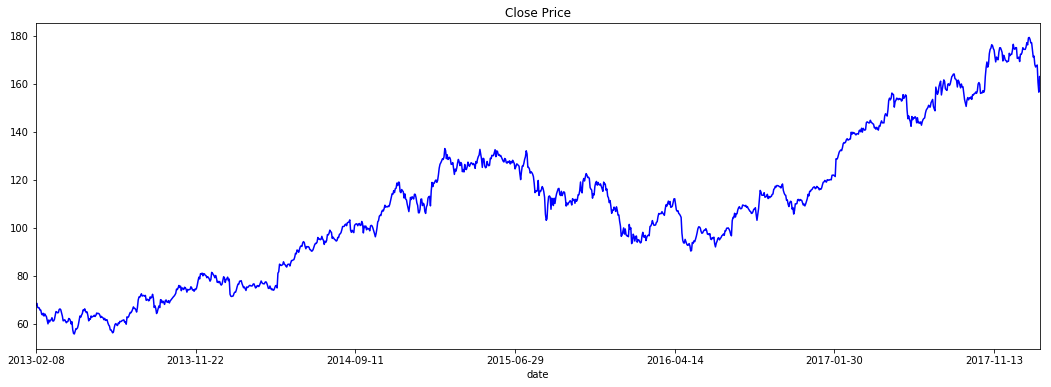

In [7]:
# display the data 
plt.figure(figsize=(18,6))
# all data points
df_close.plot(title='Close Price', color='blue') 
plt.show()

We are going to predict the Rate of Change (ROC) of the close price. 

In [9]:
#Calculate ROC
df_roc = df_close.pct_change()

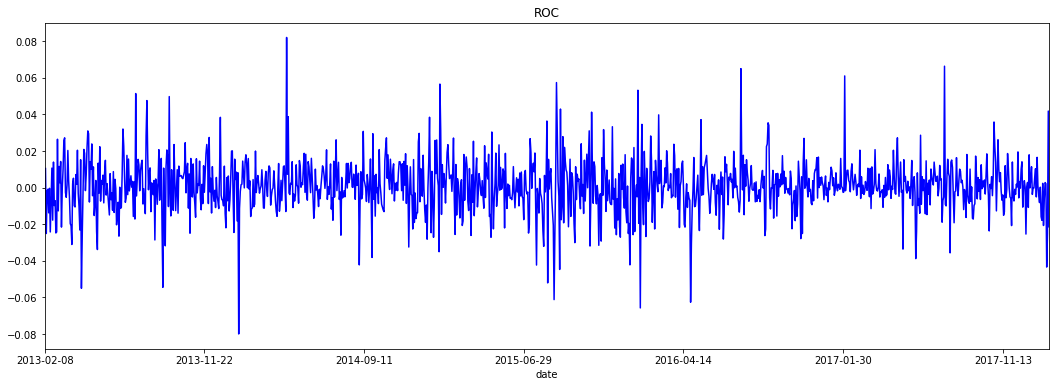

In [139]:
# display the data 
plt.figure(figsize=(18,6))
# all data points
df_roc.plot(title='ROC', color='blue') 
plt.show()

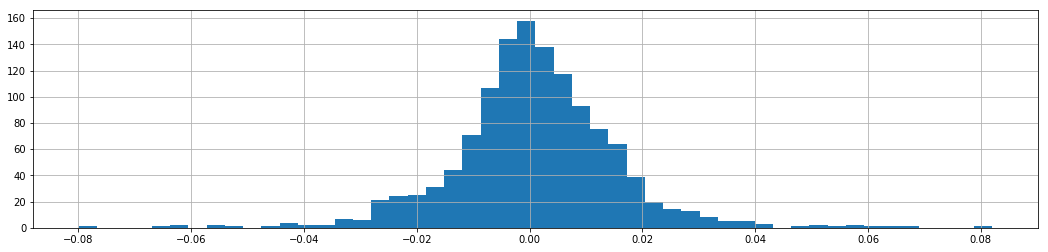

In [129]:
# Show the distribution of ROC. It approximately follows the normal distribution with mean=0 
plt.figure(figsize=(18,4))
df_roc.hist(bins=50)
plt.show()

---
## Create Time Series 

My goal will be to take full years of data, from 2014-2016, and see if I can use it to accurately predict the close price for the next several months in 2017!

Next, let's make one time series for each complete year of data. This is just a design decision, and I am deciding to use full years of data, starting in January of 2014 because there are not that many data points in the begining of 2013.

The function `make_time_series` will create pandas `Series` for each of the passed in list of years `['2014', '2015', '2016']`.

In [16]:
def make_time_series(close_price_df, years, freq='D', start_idx=226):
    '''Creates as many time series as there are complete years.
      :param close_price_df: A dataframe of global close price.This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2014', '2015'].
      :param freq: The frequency of data recording (D = daily)
      :param start_idx: The starting dataframe index of the first point in the first time series.
          The default, 226, points to '2014-01-02'. 
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
    
    # create time series for each year in years
    for i in range(len(years)):

        year = years[i]
        end_idx = start_idx+252

        # get close price data
        data = mean_power_df[start_idx:end_idx]

        # create time series for the year
        index = pd.DatetimeIndex(data.index)
        time_series.append(pd.Series(data=data, index=index))
        
        start_idx = end_idx
    
    # return list of time series
    return time_series
    

## The results of constructed time series

Below, let's construct one time series for each complete year of data, and display the results.

In [17]:
# yearly time series for our 4 complete years
full_years_ = ['2014', '2015', '2016','2017']
freq='D' # daily recordings

# make time series
time_series_ = make_time_series(df_roc, full_years_, freq=freq)

In [18]:
# yearly time series for our 3 complete years
full_years = ['2014', '2015', '2016']
freq='D' # daily recordings

# make time series
time_series = make_time_series(df_roc, full_years, freq=freq)


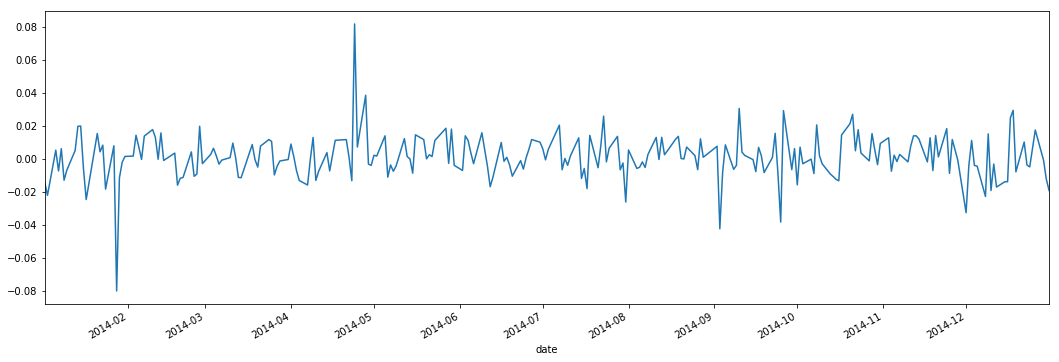

In [130]:
# display first time series
time_series_idx = 0

plt.figure(figsize=(18,6))
time_series[time_series_idx].plot()
plt.show()

---
# Splitting in Time

We'll evaluate our model on a test set of data. For machine learning tasks like classification, we typically create train/test data by randomly splitting examples into different sets. For forecasting it's important to do this train/test split in **time** rather than by individual data points. 
> In general, we can create training data by taking each of our *complete* time series and leaving off the last `prediction_length` data points to create *training* time series. 

In [51]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        # truncate trailing 20 pts
        time_series_training.append(ts[:-prediction_length])
        
    return time_series_training

In [52]:
# set prediction length
prediction_length = 20 # 20 trading days ~ a month

time_series_training = create_training_series(time_series, prediction_length)

### Training and Test Series

We can visualize what these series look like, by plotting the train/test series on the same axis. We should see that the test series contains all of our data in a year, and a training series contains all but the last `prediction_length` points.

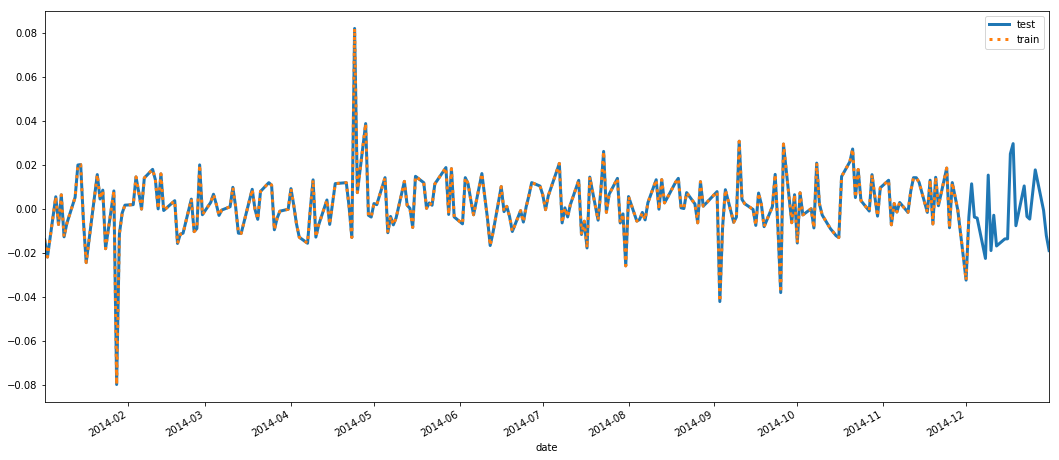

In [131]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(18,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

## Convert to JSON 

According to the [DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html), DeepAR expects to see input training data in a JSON format, with the following fields:

* **start**: A string that defines the starting date of the time series, with the format 'YYYY-MM-DD HH:MM:SS'.
* **target**: An array of numerical values that represent the time series.
* **cat** (optional): A numerical array of categorical features that can be used to encode the groups that the record belongs to. This is useful for finding models per class of item, such as in retail sales, where you might have {'shoes', 'jackets', 'pants'} encoded as categories {0, 1, 2}.

The input data should be formatted with one time series per line in a JSON file. Each line looks a bit like a dictionary, for example:
```
{"start":'2007-01-01 00:00:00', "target": [2.54, 6.3, ...], "cat": [1]}
{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [0]} 
...
```
In the above example, each time series has one, associated categorical feature and one time series feature.

In [54]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts)}
    return json_obj


In [55]:
ts = time_series[0]

json_obj = series_to_json_obj(ts)

### Saving Data, Locally

The next helper function will write one series to a single JSON line, using the new line character '\n'. The data is also encoded and written to a filename that we specify.

In [56]:
# import json for formatting data
import json
import os # and os for saving

def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [57]:
# save this data to a local directory
data_dir = 'json_roc_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [58]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_key)        
write_json_dataset(time_series, test_key)

json_roc_data/train.json saved.
json_roc_data/test.json saved.


---
## Uploading Data to S3

Next, to make this data accessible to an estimator, I'll upload it to S3.

### Sagemaker resources

Let's start by specifying:
* The sagemaker role and session for training a model.
* A default S3 bucket where we can save our training, test, and model data.

In [59]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [60]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()


### Upoad *both* training and test JSON files to S3

In [61]:
# general prefix
prefix='stock-price-prediction_roc'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [62]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-2-560774986318/stock-price-prediction_roc/train/train.json
Test data is stored in: s3://sagemaker-us-east-2-560774986318/stock-price-prediction_roc/test/test.json


---
# Training a DeepAR Estimator

Some estimators have specific, SageMaker constructors, but not all. Instead you can create a base `Estimator` and pass in the specific image (or container) that holds a specific model.

Next, we configure the container image to be used for the region that we are running in.

In [63]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image


###  Instantiate an Estimator 

In [64]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

## Setting Hyperparameters

Next, we need to define some DeepAR hyperparameters that define the model size and training behavior. Values for the epochs, frequency, prediction length, and context length are required.

* **epochs**: The maximum number of times to pass over the data when training.
* **time_freq**: The granularity of the time series in the dataset ('D' for daily).
* **prediction_length**: A string; the number of time steps (based off the unit of frequency) that the model is trained to predict. 
* **context_length**: The number of time points that the model gets to see *before* making a prediction. 

In [65]:
freq='D'
context_length=30 

hyperparameters = {
    "epochs": "100",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "100",
    "num_layers": "2",
    "mini_batch_size": "64",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [66]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

## Training Job

Now, we are ready to launch the training job! SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the *actual* value of the time series. The computed error metrics will be included as part of the log output.

The next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [67]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-07-02 06:42:39 Starting - Starting the training job...
2020-07-02 06:42:41 Starting - Launching requested ML instances......
2020-07-02 06:43:44 Starting - Preparing the instances for training...
2020-07-02 06:44:31 Downloading - Downloading input data......
2020-07-02 06:45:26 Training - Training image download completed. Training in progress.Arguments: train
[07/02/2020 06:45:29 INFO 140645314668352] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': 

[07/02/2020 06:45:37 INFO 140645314668352] Epoch[3] Batch[5] avg_epoch_loss=-2.884753
[07/02/2020 06:45:37 INFO 140645314668352] #quality_metric: host=algo-1, epoch=3, batch=5 train loss <loss>=-2.88475271066
[07/02/2020 06:45:37 INFO 140645314668352] Epoch[3] Batch [5]#011Speed: 415.18 samples/sec#011loss=-2.884753
[07/02/2020 06:45:37 INFO 140645314668352] Epoch[3] Batch[10] avg_epoch_loss=-2.912349
[07/02/2020 06:45:37 INFO 140645314668352] #quality_metric: host=algo-1, epoch=3, batch=10 train loss <loss>=-2.94546499252
[07/02/2020 06:45:37 INFO 140645314668352] Epoch[3] Batch [10]#011Speed: 400.27 samples/sec#011loss=-2.945465
[07/02/2020 06:45:37 INFO 140645314668352] processed a total of 654 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1909.419059753418, "sum": 1909.419059753418, "min": 1909.419059753418}}, "EndTime": 1593672337.80744, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672335.897957}

[07/02

[07/02/2020 06:45:47 INFO 140645314668352] Epoch[8] Batch[10] avg_epoch_loss=-3.278661
[07/02/2020 06:45:47 INFO 140645314668352] #quality_metric: host=algo-1, epoch=8, batch=10 train loss <loss>=-3.33148555756
[07/02/2020 06:45:47 INFO 140645314668352] Epoch[8] Batch [10]#011Speed: 417.91 samples/sec#011loss=-3.331486
[07/02/2020 06:45:47 INFO 140645314668352] processed a total of 659 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1859.699010848999, "sum": 1859.699010848999, "min": 1859.699010848999}}, "EndTime": 1593672347.125942, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672345.266104}

[07/02/2020 06:45:47 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=354.33593201 records/second
[07/02/2020 06:45:47 INFO 140645314668352] #progress_metric: host=algo-1, completed 9 % of epochs
[07/02/2020 06:45:47 INFO 140645314668352] #quality_metric: host=algo-1, epoch=8, train loss <loss>=-3.2

[07/02/2020 06:45:57 INFO 140645314668352] Epoch[14] Batch[5] avg_epoch_loss=-3.603602
[07/02/2020 06:45:57 INFO 140645314668352] #quality_metric: host=algo-1, epoch=14, batch=5 train loss <loss>=-3.60360173384
[07/02/2020 06:45:57 INFO 140645314668352] Epoch[14] Batch [5]#011Speed: 419.10 samples/sec#011loss=-3.603602
[07/02/2020 06:45:57 INFO 140645314668352] processed a total of 638 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1735.8670234680176, "sum": 1735.8670234680176, "min": 1735.8670234680176}}, "EndTime": 1593672357.929151, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672356.192709}

[07/02/2020 06:45:57 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=367.504542639 records/second
[07/02/2020 06:45:57 INFO 140645314668352] #progress_metric: host=algo-1, completed 15 % of epochs
[07/02/2020 06:45:57 INFO 140645314668352] #quality_metric: host=algo-1, epoch=14, train loss <loss

[07/02/2020 06:46:06 INFO 140645314668352] processed a total of 635 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1764.754056930542, "sum": 1764.754056930542, "min": 1764.754056930542}}, "EndTime": 1593672366.876412, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672365.110927}

[07/02/2020 06:46:06 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=359.795803706 records/second
[07/02/2020 06:46:06 INFO 140645314668352] #progress_metric: host=algo-1, completed 20 % of epochs
[07/02/2020 06:46:06 INFO 140645314668352] #quality_metric: host=algo-1, epoch=19, train loss <loss>=-3.9432549715
[07/02/2020 06:46:06 INFO 140645314668352] best epoch loss so far
[07/02/2020 06:46:06 INFO 140645314668352] Saved checkpoint to "/opt/ml/model/state_0f557518-987b-4c3b-951d-5fca52fbf5e5-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 31.475067138671875, "sum": 31.475067138671

[07/02/2020 06:46:16 INFO 140645314668352] Epoch[25] Batch[5] avg_epoch_loss=-4.016483
[07/02/2020 06:46:16 INFO 140645314668352] #quality_metric: host=algo-1, epoch=25, batch=5 train loss <loss>=-4.01648263137
[07/02/2020 06:46:16 INFO 140645314668352] Epoch[25] Batch [5]#011Speed: 422.21 samples/sec#011loss=-4.016483
[07/02/2020 06:46:17 INFO 140645314668352] Epoch[25] Batch[10] avg_epoch_loss=-4.030418
[07/02/2020 06:46:17 INFO 140645314668352] #quality_metric: host=algo-1, epoch=25, batch=10 train loss <loss>=-4.04713993073
[07/02/2020 06:46:17 INFO 140645314668352] Epoch[25] Batch [10]#011Speed: 419.82 samples/sec#011loss=-4.047140
[07/02/2020 06:46:17 INFO 140645314668352] processed a total of 662 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1911.3380908966064, "sum": 1911.3380908966064, "min": 1911.3380908966064}}, "EndTime": 1593672377.670264, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672375.75886

[07/02/2020 06:46:26 INFO 140645314668352] Epoch[30] Batch[10] avg_epoch_loss=-4.065877
[07/02/2020 06:46:26 INFO 140645314668352] #quality_metric: host=algo-1, epoch=30, batch=10 train loss <loss>=-3.97719092369
[07/02/2020 06:46:26 INFO 140645314668352] Epoch[30] Batch [10]#011Speed: 420.75 samples/sec#011loss=-3.977191
[07/02/2020 06:46:26 INFO 140645314668352] processed a total of 650 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1911.1151695251465, "sum": 1911.1151695251465, "min": 1911.1151695251465}}, "EndTime": 1593672386.964356, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672385.053177}

[07/02/2020 06:46:26 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=340.093663996 records/second
[07/02/2020 06:46:26 INFO 140645314668352] #progress_metric: host=algo-1, completed 31 % of epochs
[07/02/2020 06:46:26 INFO 140645314668352] #quality_metric: host=algo-1, epoch=30, train loss <l

[07/02/2020 06:46:37 INFO 140645314668352] Epoch[36] Batch[5] avg_epoch_loss=-4.353771
[07/02/2020 06:46:37 INFO 140645314668352] #quality_metric: host=algo-1, epoch=36, batch=5 train loss <loss>=-4.35377105077
[07/02/2020 06:46:37 INFO 140645314668352] Epoch[36] Batch [5]#011Speed: 422.26 samples/sec#011loss=-4.353771
[07/02/2020 06:46:37 INFO 140645314668352] processed a total of 639 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1702.6071548461914, "sum": 1702.6071548461914, "min": 1702.6071548461914}}, "EndTime": 1593672397.835572, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672396.132871}

[07/02/2020 06:46:37 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=375.272196933 records/second
[07/02/2020 06:46:37 INFO 140645314668352] #progress_metric: host=algo-1, completed 37 % of epochs
[07/02/2020 06:46:37 INFO 140645314668352] #quality_metric: host=algo-1, epoch=36, train loss <loss

[07/02/2020 06:46:47 INFO 140645314668352] Epoch[41] Batch[10] avg_epoch_loss=-4.493851
[07/02/2020 06:46:47 INFO 140645314668352] #quality_metric: host=algo-1, epoch=41, batch=10 train loss <loss>=-4.56876220703
[07/02/2020 06:46:47 INFO 140645314668352] Epoch[41] Batch [10]#011Speed: 408.65 samples/sec#011loss=-4.568762
[07/02/2020 06:46:47 INFO 140645314668352] processed a total of 666 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1880.1608085632324, "sum": 1880.1608085632324, "min": 1880.1608085632324}}, "EndTime": 1593672407.116703, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672405.235925}

[07/02/2020 06:46:47 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=354.201439398 records/second
[07/02/2020 06:46:47 INFO 140645314668352] #progress_metric: host=algo-1, completed 42 % of epochs
[07/02/2020 06:46:47 INFO 140645314668352] #quality_metric: host=algo-1, epoch=41, train loss <l

[07/02/2020 06:46:57 INFO 140645314668352] Epoch[47] Batch[5] avg_epoch_loss=-4.492705
[07/02/2020 06:46:57 INFO 140645314668352] #quality_metric: host=algo-1, epoch=47, batch=5 train loss <loss>=-4.49270526568
[07/02/2020 06:46:57 INFO 140645314668352] Epoch[47] Batch [5]#011Speed: 423.24 samples/sec#011loss=-4.492705
[07/02/2020 06:46:58 INFO 140645314668352] processed a total of 609 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1727.8869152069092, "sum": 1727.8869152069092, "min": 1727.8869152069092}}, "EndTime": 1593672418.083376, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672416.355422}

[07/02/2020 06:46:58 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=352.428917445 records/second
[07/02/2020 06:46:58 INFO 140645314668352] #progress_metric: host=algo-1, completed 48 % of epochs
[07/02/2020 06:46:58 INFO 140645314668352] #quality_metric: host=algo-1, epoch=47, train loss <loss

[07/02/2020 06:47:07 INFO 140645314668352] processed a total of 608 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1689.4199848175049, "sum": 1689.4199848175049, "min": 1689.4199848175049}}, "EndTime": 1593672427.347719, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672425.658223}

[07/02/2020 06:47:07 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=359.858947377 records/second
[07/02/2020 06:47:07 INFO 140645314668352] #progress_metric: host=algo-1, completed 53 % of epochs
[07/02/2020 06:47:07 INFO 140645314668352] #quality_metric: host=algo-1, epoch=52, train loss <loss>=-4.67955832481
[07/02/2020 06:47:07 INFO 140645314668352] best epoch loss so far
[07/02/2020 06:47:07 INFO 140645314668352] Saved checkpoint to "/opt/ml/model/state_5270ecdb-fc42-40f9-a95d-76117799e7af-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 30.72500228881836, "sum": 30.725002288

[07/02/2020 06:47:17 INFO 140645314668352] Epoch[58] Batch[5] avg_epoch_loss=-4.674167
[07/02/2020 06:47:17 INFO 140645314668352] #quality_metric: host=algo-1, epoch=58, batch=5 train loss <loss>=-4.67416723569
[07/02/2020 06:47:17 INFO 140645314668352] Epoch[58] Batch [5]#011Speed: 423.24 samples/sec#011loss=-4.674167
[07/02/2020 06:47:18 INFO 140645314668352] processed a total of 630 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1712.8679752349854, "sum": 1712.8679752349854, "min": 1712.8679752349854}}, "EndTime": 1593672438.071428, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672436.358502}

[07/02/2020 06:47:18 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=367.768089994 records/second
[07/02/2020 06:47:18 INFO 140645314668352] #progress_metric: host=algo-1, completed 59 % of epochs
[07/02/2020 06:47:18 INFO 140645314668352] #quality_metric: host=algo-1, epoch=58, train loss <loss

[07/02/2020 06:47:27 INFO 140645314668352] Epoch[63] Batch[10] avg_epoch_loss=-4.784161
[07/02/2020 06:47:27 INFO 140645314668352] #quality_metric: host=algo-1, epoch=63, batch=10 train loss <loss>=-4.85238180161
[07/02/2020 06:47:27 INFO 140645314668352] Epoch[63] Batch [10]#011Speed: 419.51 samples/sec#011loss=-4.852382
[07/02/2020 06:47:27 INFO 140645314668352] processed a total of 646 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1856.562852859497, "sum": 1856.562852859497, "min": 1856.562852859497}}, "EndTime": 1593672447.20649, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672445.349451}

[07/02/2020 06:47:27 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=347.93136603 records/second
[07/02/2020 06:47:27 INFO 140645314668352] #progress_metric: host=algo-1, completed 64 % of epochs
[07/02/2020 06:47:27 INFO 140645314668352] #quality_metric: host=algo-1, epoch=63, train loss <loss>=

[07/02/2020 06:47:36 INFO 140645314668352] Epoch[69] Batch[0] avg_epoch_loss=-4.819400
[07/02/2020 06:47:36 INFO 140645314668352] #quality_metric: host=algo-1, epoch=69, batch=0 train loss <loss>=-4.81940031052
[07/02/2020 06:47:37 INFO 140645314668352] Epoch[69] Batch[5] avg_epoch_loss=-4.806297
[07/02/2020 06:47:37 INFO 140645314668352] #quality_metric: host=algo-1, epoch=69, batch=5 train loss <loss>=-4.8062971433
[07/02/2020 06:47:37 INFO 140645314668352] Epoch[69] Batch [5]#011Speed: 422.53 samples/sec#011loss=-4.806297
[07/02/2020 06:47:38 INFO 140645314668352] Epoch[69] Batch[10] avg_epoch_loss=-4.731695
[07/02/2020 06:47:38 INFO 140645314668352] #quality_metric: host=algo-1, epoch=69, batch=10 train loss <loss>=-4.64217348099
[07/02/2020 06:47:38 INFO 140645314668352] Epoch[69] Batch [10]#011Speed: 419.51 samples/sec#011loss=-4.642173
[07/02/2020 06:47:38 INFO 140645314668352] processed a total of 651 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1904.683113

[07/02/2020 06:47:46 INFO 140645314668352] Epoch[74] Batch[5] avg_epoch_loss=-4.818023
[07/02/2020 06:47:46 INFO 140645314668352] #quality_metric: host=algo-1, epoch=74, batch=5 train loss <loss>=-4.81802280744
[07/02/2020 06:47:46 INFO 140645314668352] Epoch[74] Batch [5]#011Speed: 423.28 samples/sec#011loss=-4.818023
[07/02/2020 06:47:47 INFO 140645314668352] processed a total of 636 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1702.6450634002686, "sum": 1702.6450634002686, "min": 1702.6450634002686}}, "EndTime": 1593672467.562637, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672465.859465}

[07/02/2020 06:47:47 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=373.511244708 records/second
[07/02/2020 06:47:47 INFO 140645314668352] #progress_metric: host=algo-1, completed 75 % of epochs
[07/02/2020 06:47:47 INFO 140645314668352] #quality_metric: host=algo-1, epoch=74, train loss <loss

[07/02/2020 06:47:56 INFO 140645314668352] Epoch[79] Batch[10] avg_epoch_loss=-4.947643
[07/02/2020 06:47:56 INFO 140645314668352] #quality_metric: host=algo-1, epoch=79, batch=10 train loss <loss>=-5.05353384018
[07/02/2020 06:47:56 INFO 140645314668352] Epoch[79] Batch [10]#011Speed: 419.98 samples/sec#011loss=-5.053534
[07/02/2020 06:47:56 INFO 140645314668352] processed a total of 674 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1869.9538707733154, "sum": 1869.9538707733154, "min": 1869.9538707733154}}, "EndTime": 1593672476.813078, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672474.942587}

[07/02/2020 06:47:56 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=360.410460029 records/second
[07/02/2020 06:47:56 INFO 140645314668352] #progress_metric: host=algo-1, completed 80 % of epochs
[07/02/2020 06:47:56 INFO 140645314668352] #quality_metric: host=algo-1, epoch=79, train loss <l

[07/02/2020 06:48:07 INFO 140645314668352] Epoch[85] Batch[10] avg_epoch_loss=-4.971474
[07/02/2020 06:48:07 INFO 140645314668352] #quality_metric: host=algo-1, epoch=85, batch=10 train loss <loss>=-4.96687355042
[07/02/2020 06:48:07 INFO 140645314668352] Epoch[85] Batch [10]#011Speed: 425.56 samples/sec#011loss=-4.966874
[07/02/2020 06:48:07 INFO 140645314668352] processed a total of 656 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1848.879098892212, "sum": 1848.879098892212, "min": 1848.879098892212}}, "EndTime": 1593672487.405688, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672485.556313}

[07/02/2020 06:48:07 INFO 140645314668352] #throughput_metric: host=algo-1, train throughput=354.788296821 records/second
[07/02/2020 06:48:07 INFO 140645314668352] #progress_metric: host=algo-1, completed 86 % of epochs
[07/02/2020 06:48:07 INFO 140645314668352] #quality_metric: host=algo-1, epoch=85, train loss <loss

[07/02/2020 06:48:17 INFO 140645314668352] Epoch[91] Batch[5] avg_epoch_loss=-4.937537
[07/02/2020 06:48:17 INFO 140645314668352] #quality_metric: host=algo-1, epoch=91, batch=5 train loss <loss>=-4.93753671646
[07/02/2020 06:48:17 INFO 140645314668352] Epoch[91] Batch [5]#011Speed: 418.24 samples/sec#011loss=-4.937537
[07/02/2020 06:48:18 INFO 140645314668352] Epoch[91] Batch[10] avg_epoch_loss=-4.961882
[07/02/2020 06:48:18 INFO 140645314668352] #quality_metric: host=algo-1, epoch=91, batch=10 train loss <loss>=-4.99109716415
[07/02/2020 06:48:18 INFO 140645314668352] Epoch[91] Batch [10]#011Speed: 422.66 samples/sec#011loss=-4.991097
[07/02/2020 06:48:18 INFO 140645314668352] processed a total of 643 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1886.73996925354, "sum": 1886.73996925354, "min": 1886.73996925354}}, "EndTime": 1593672498.1351, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593672496.248297}

[07/


2020-07-02 06:48:46 Completed - Training job completed
Training seconds: 255
Billable seconds: 255
CPU times: user 1.02 s, sys: 35 ms, total: 1.05 s
Wall time: 6min 43s


## Training Result:
       test:RMSE: The root mean square error between the forecast and the actual target computed on the test set.
       0.0149326097809
       
       test:mean_wQuantileLoss: The average overall quantile losses computed on the test set. To control which quantiles are          used, set the test_quantiles hyperparameter.
       1.05884942

## Deploy and Create a Predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to a predictor endpoint.

In [68]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

-----------------!CPU times: user 275 ms, sys: 21.2 ms, total: 297 ms
Wall time: 8min 31s


---
# Generating Predictions

According to the [inference format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) for DeepAR, the `predictor` expects to see input data in a JSON format, with the following keys:
* **instances**: A list of JSON-formatted time series that should be forecast by the model.
* **configuration** (optional): A dictionary of configuration information for the type of response desired by the request.

Within configuration the following keys can be configured:
* **num_samples**: An integer specifying the number of samples that the model generates when making a probabilistic prediction.
* **output_types**: A list specifying the type of response. We'll ask for **quantiles**, which look at the list of num_samples generated by the model, and generate [quantile estimates](https://en.wikipedia.org/wiki/Quantile) for each time point based on these values.
* **quantiles**: A list that specified which quantiles estimates are generated and returned in the response.


Below is an example of what a JSON query to a DeepAR model endpoint might look like.

```
{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0] },
  { "start": "1999-01-30", "target": [2.0, 1.0] }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["quantiles"],
  "quantiles": ["0.5", "0.9"]
 }
}
```


## JSON Prediction Request

The code below accepts a **list** of time series as input and some configuration parameters. It then formats that series into a JSON instance and converts the input into an appropriately formatted JSON_input.

In [69]:
def json_predictor_input(input_ts, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series
        instances.append(series_to_json_obj(input_ts[k]))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

### Get a Prediction

We can then use this function to get a prediction for a formatted time series!

In the next cell, I'm getting an input time series and known target, and passing the formatted input into the predictor endpoint to get a resultant prediction.

In [70]:
# get all input and target (test) time series
input_ts = time_series_training
target_ts = time_series

# get formatted input time series
json_input_ts = json_predictor_input(input_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

#print(json_prediction)

## Decoding Predictions

The predictor returns JSON-formatted prediction, and so we need to extract the predictions and quantile data that we want for visualizing the result. The function below, reads in a JSON-formatted prediction and produces a list of predictions in each quantile.

In [71]:
# helper function to decode JSON prediction
def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list


In [72]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of 20 predictions 
# with corresponding quantile values
print(prediction_list[0])

         0.1       0.9       0.5
0  -0.001732 -0.000207 -0.001004
1  -0.002354 -0.000220 -0.001308
2  -0.004210 -0.003322 -0.003703
3  -0.001433 -0.000549 -0.000945
4   0.000055  0.001273  0.000714
5   0.000059  0.002884  0.001644
6  -0.003311 -0.000821 -0.002043
7  -0.005268 -0.002172 -0.003383
8   0.001430  0.004687  0.003112
9   0.000307  0.002334  0.001507
10  0.000487  0.002461  0.001377
11  0.007222  0.010688  0.009039
12  0.002889  0.004426  0.003661
13 -0.007352 -0.003173 -0.005204
14  0.002391  0.009654  0.006431
15 -0.005523 -0.000234 -0.002380
16 -0.009104  0.004140 -0.001043
17 -0.005806 -0.003382 -0.004380
18 -0.004339 -0.000691 -0.002209
19  0.000137  0.005504  0.002907


## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantile 0.5 represents the median of all sample predictions.


In [132]:
# display the prediction median against the actual data
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(18,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')

        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

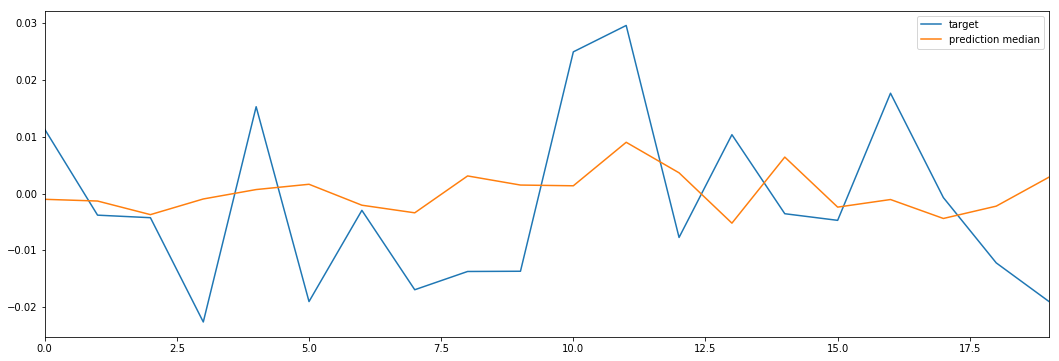

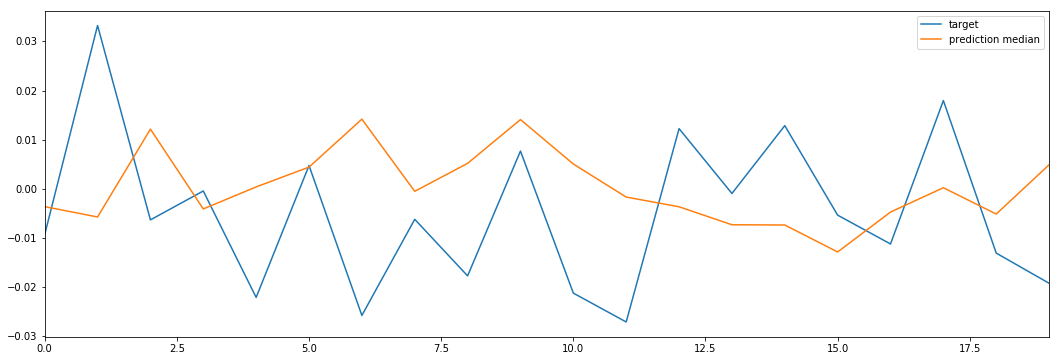

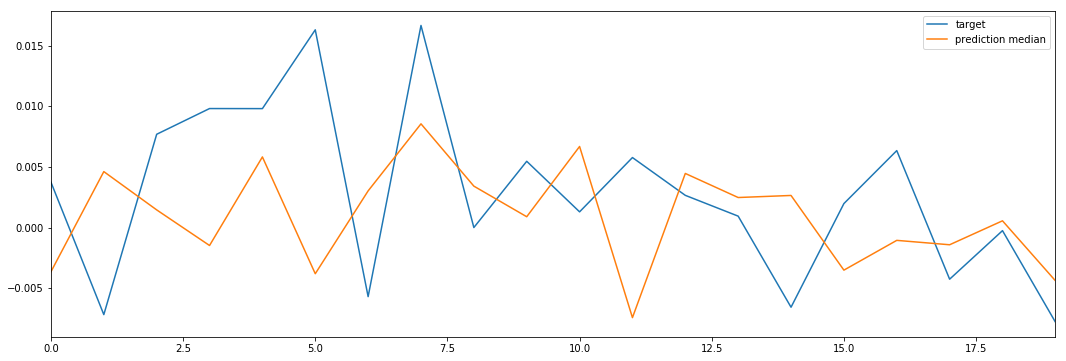

In [133]:
# display predictions
display_quantiles(prediction_list, target_ts)

## Predicting the Future

Recall that we did not give our model any data about 2010, but let's see if it can predict the close given **no target**, only a known start date!

In [102]:
# Starting my prediction at the beginning of 2017
start_date_1 = '2017-01-03'
start_date_2 = '2017-02-01'
start_date_3 = '2017-03-02'

# formatting request_data
# this instance has an empty target!
request_data_1 = {"instances": [{"start": start_date_1, "target": []}],
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }

request_data_2 = {"instances": [{"start": start_date_2, "target": []}],
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }

request_data_3 = {"instances": [{"start": start_date_3, "target": []}],
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }


json_input_1 = json.dumps(request_data_1).encode('utf-8')
json_input_2 = json.dumps(request_data_2).encode('utf-8')
json_input_3 = json.dumps(request_data_3).encode('utf-8')

print('Requesting prediction for '+start_date_1)
print('Requesting prediction for '+start_date_2)
print('Requesting prediction for '+start_date_3)

Requesting prediction for 2017-01-03
Requesting prediction for 2017-02-01
Requesting prediction for 2017-03-02


Then get and decode the prediction response, as usual.

In [103]:
# get prediction response
json_prediction_1 = predictor.predict(json_input_1)
prediction_2017_1 = decode_prediction(json_prediction_1)

json_prediction_2 = predictor.predict(json_input_2)
prediction_2017_2 = decode_prediction(json_prediction_2)

json_prediction_3 = predictor.predict(json_input_3)
prediction_2017_3 = decode_prediction(json_prediction_3)

Finally, I'll compare the predictions to a known target sequence. This target will come from a time series for the 2017 data, which I'm creating below.

In [110]:
ts_2017_1_ = time_series_[3][:20]
ts_2017_2_ = time_series_[3][20:40]
ts_2017_3_ = time_series_[3][40:60]

ts_2017_1=[]
ts_2017_2=[]
ts_2017_3=[]

ts_2017_1.append(ts_2017_1_)
ts_2017_2.append(ts_2017_2_)
ts_2017_3.append(ts_2017_3_)

In [134]:
# display the prediction median against the actual data
# This time, we would like to show the 0.1, 0.9 quantiles and the 80% CI

def display_quantiles_(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(18,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

In [123]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
import math

def calculate_rmse(y_true, y_predict):
    mse = mean_squared_error(y_true, y_predict)
    rmse = math.sqrt(mse)
    return rmse

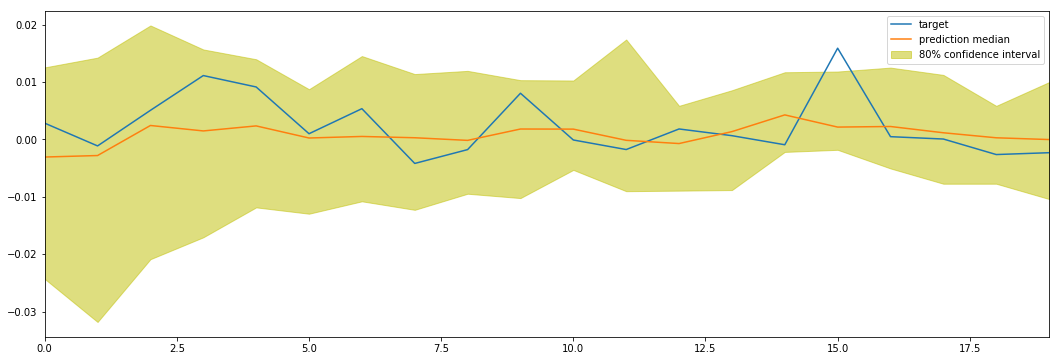

rmse for first 20 trading days: 
0.0050848803184042534


In [135]:
# display predictions for the first 20 trading days
display_quantiles_(prediction_2017_1, ts_2017_1)

# calculate rmse for first 20 trading days
rmse_1 = calculate_rmse(ts_2017_1_, prediction_2017_1[0]['0.5'])
print("rmse for first 20 trading days: ")
print(rmse_1)

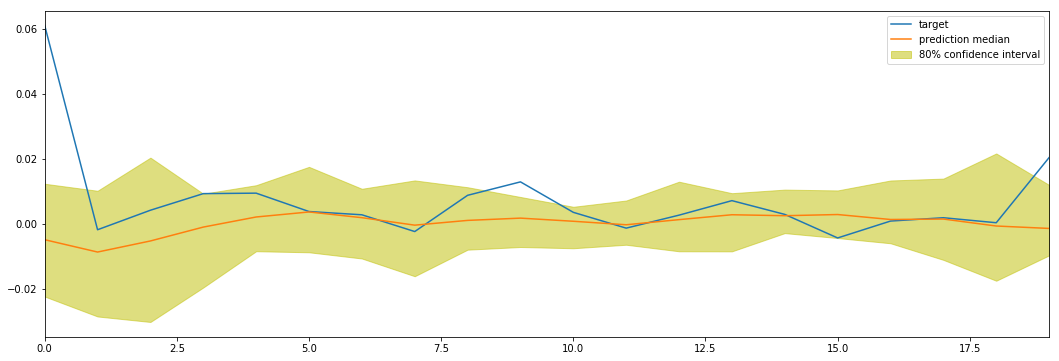

rmse for first 20 trading days: 
0.016372285316725375


In [136]:
# display predictions for the second 20 trading days (day 20 - day 40)
display_quantiles_(prediction_2017_2, ts_2017_2)

# calculate rmse for first 20 trading days
rmse_2 = calculate_rmse(ts_2017_2_, prediction_2017_2[0]['0.5'])
print("rmse for first 20 trading days: ")
print(rmse_2)

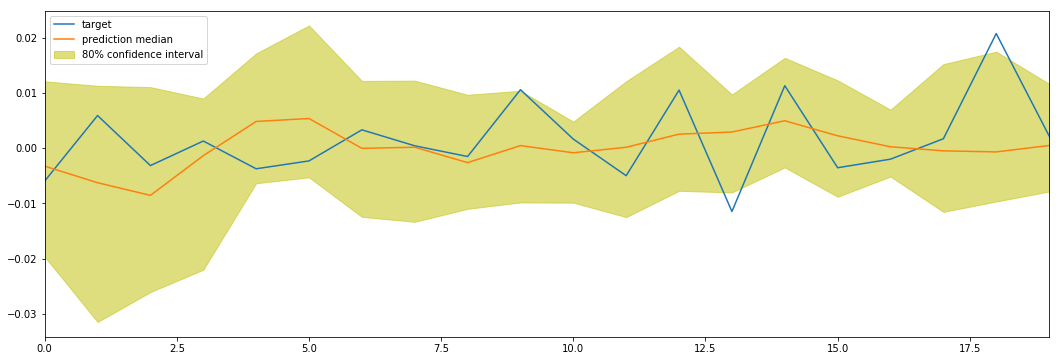

rmse for first 20 trading days: 
0.008013909721949828


In [137]:
# display predictions for the third 20 trading days (day 40 - day 60)
display_quantiles_(prediction_2017_3, ts_2017_3)

# calculate rmse for first 20 trading days
rmse_3 = calculate_rmse(ts_2017_3_, prediction_2017_3[0]['0.5'])
print("rmse for first 20 trading days: ")
print(rmse_3)

## Delete the Endpoint

In [138]:
predictor.delete_endpoint()

## Conclusion

From the plot, we can see that the prediction for next 60 trading days in 2017 is pretty good. The prediction median follows the trend of the actual close price. Nearly all actual close price points are in the 80% confidence interval.The prediction RMSE is also very small.